##Final model on MobileNetV2

###Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
import glob
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

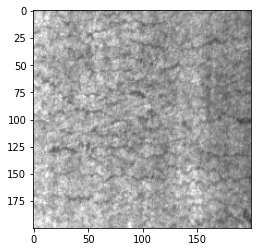

In [ ]:
#Check path is correct or not
img = cv2.imread("/content/gdrive/MyDrive/Btp/IMAGES/crazing_1.jpg", cv2.IMREAD_COLOR)
plt.imshow(img)

###It is used to store data in python list 

In [ ]:
image = []                  # used to store image data /content/gdrive/MyDrive/Object_detection/Data/train/images/img1.jpeg
img_label = []  
           # used to store image label
defect=['pitted_surface_','inclusion_','patches_','crazing_','rolled-in_scale_','scratches_']
for k in range(6):
  for i in range(1,300):
      j= defect[k]+str(i)+'.jpg'
      if ((Path.cwd() / "/content/gdrive/MyDrive/Btp/IMAGES" / j).exists() == True):         # check if image exists or not
          img = cv2.imread("/content/gdrive/MyDrive/Btp/IMAGES/" + j, cv2.IMREAD_COLOR)       # read image using opencv 
          img = cv2.resize(img, (224,224))                                                                   #resize image 
          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)                                                                 #resize image 
          img_label.append(defect[k])
          image.append(img) 
          
      else:
         pass

In [ ]:
len(image), len(img_label)

(1765, 1765)

In [ ]:
#total number of original training images
len(image)

1765

In [ ]:
len(img_label)

1765

In [ ]:
#convert into numpy array
image=np.array(image)
img_label=np.array(img_label)

###Visualize the plot of number of training data

(array([293.,   0., 295.,   0., 294.,   0., 294.,   0., 294., 295.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

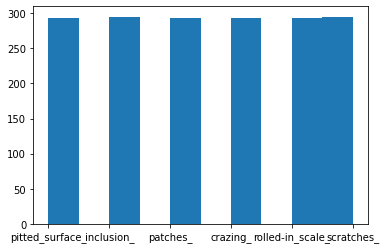

In [ ]:
plt.hist(img_label)

In [ ]:
img_label

array(['pitted_surface_', 'pitted_surface_', 'pitted_surface_', ...,
       'scratches_', 'scratches_', 'scratches_'], dtype='<U16')

In [ ]:
print(image.shape)
print(image.shape[1])
print(image.shape[2])
f = (image.shape[0], image.shape[2])
print(f)

(1765, 224, 224, 3)
224
224
(1765, 224)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image, img_label, test_size = 0.2, random_state = 100)

In [ ]:
test_img=[]
for i in range(len(x_test)):
    test_img.append(x_test[i]/255.0)

In [ ]:
x_test=np.array(test_img)

In [ ]:
df2 = pd.DataFrame(list(zip(x_test, y_test)),columns =['Image','label'])
df2.head()

,Image,label
0,"[[[0.6941176470588235, 0.6941176470588235, 0.6...",patches_
1,"[[[0.41568627450980394, 0.41568627450980394, 0...",scratches_
2,"[[[0.2627450980392157, 0.2627450980392157, 0.2...",scratches_
3,"[[[0.48627450980392156, 0.48627450980392156, 0...",scratches_
4,"[[[0.7725490196078432, 0.7725490196078432, 0.7...",pitted_surface_


In [ ]:
df2=pd.concat([df2['Image'],pd.get_dummies(df2["label"])], axis=1)
df2.head()

,Image,crazing_,inclusion_,patches_,pitted_surface_,rolled-in_scale_,scratches_
0,"[[[0.6941176470588235, 0.6941176470588235, 0.6...",0,0,1,0,0,0
1,"[[[0.41568627450980394, 0.41568627450980394, 0...",0,0,0,0,0,1
2,"[[[0.2627450980392157, 0.2627450980392157, 0.2...",0,0,0,0,0,1
3,"[[[0.48627450980392156, 0.48627450980392156, 0...",0,0,0,0,0,1
4,"[[[0.7725490196078432, 0.7725490196078432, 0.7...",0,0,0,1,0,0


In [ ]:
y_test= df2[df2.columns[1:]].to_numpy()

In [ ]:
y_test.shape

(353, 6)

In [ ]:
x_test=[]
for i in range(len(y_test)):
  x_test.append(df2["Image"][i])
x_test=np.array(x_test)

In [ ]:
x_test.shape

(353, 224, 224, 3)

In [ ]:
#Make a dataframe by concatenating all the numpy array
df1 = pd.DataFrame(list(zip(x_train, y_train)),columns =['Image','label'])
df1.head()

,Image,label
0,"[[[16, 16, 16], [17, 17, 17], [12, 12, 12], [1...",patches_
1,"[[[155, 155, 155], [143, 143, 143], [147, 147,...",rolled-in_scale_
2,"[[[73, 73, 73], [73, 73, 73], [73, 73, 73], [7...",inclusion_
3,"[[[107, 107, 107], [106, 106, 106], [104, 104,...",rolled-in_scale_
4,"[[[143, 143, 143], [138, 138, 138], [138, 138,...",crazing_


##Applied different data-augmentation techniques and try to make balance training samples 

In [ ]:
a_f=[]
a_level=[]
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
])

for i in range(len(x_train)):
  augmented_image = data_augmentation(df1["Image"][i])
  a_f.append(augmented_image)
  a_level.append(df1["label"][i])
  

In [ ]:
len(a_f), len(a_level)

(1412, 1412)

###Added approx 700 blur images

In [ ]:
for i in range(len(x_train)//2):
  x = cv2.blur(np.array(df1["Image"][i]), (3,3))
  a_f.append(x)
  a_level.append(df1["label"][i])

In [ ]:
len(a_f), len(a_level)

(2118, 2118)

In [ ]:
final_train_image = np.array(a_f)
final_train_label = np.array(a_level)

In [ ]:
final_train_image = np.concatenate((final_train_image, x_train), axis=0)
final_train_label = np.concatenate((final_train_label, y_train), axis=0)

In [ ]:
final_train_image.shape, final_train_label.shape

((3530, 224, 224, 3), (3530,))

In [ ]:
#scale data
all_img = []
for i in range(len(final_train_image)):
    all_img.append(final_train_image[i]/255.0)

    

In [ ]:
final_train_image=np.array(all_img)

In [ ]:
final_train_image.shape, final_train_label.shape

((3530, 224, 224, 3), (3530,))

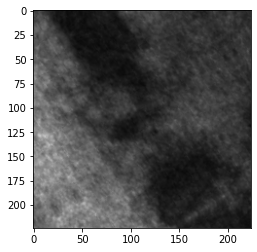

In [ ]:
plt.imshow(final_train_image[0])

(array([592.,   0., 602.,   0., 604.,   0., 584.,   0., 581., 567.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

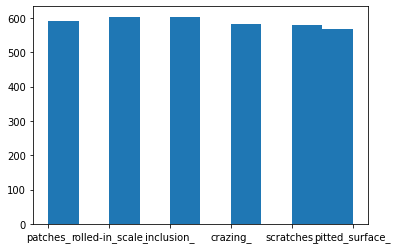

In [ ]:
plt.hist(final_train_label)

In [ ]:
df = pd.DataFrame(list(zip(final_train_image, final_train_label)),columns =['Image','label'])
df.head()

,Image,label
0,"[[[0.26796442, 0.26796442, 0.26796442], [0.245...",patches_
1,"[[[0.39521956, 0.39521956, 0.39521956], [0.408...",rolled-in_scale_
2,"[[[0.26920357, 0.26920357, 0.26920357], [0.272...",inclusion_
3,"[[[0.49775815, 0.49775815, 0.49775815], [0.490...",rolled-in_scale_
4,"[[[0.5757388, 0.5757388, 0.5757388], [0.609691...",crazing_


In [ ]:
df=pd.concat([df['Image'],pd.get_dummies(df["label"])], axis=1)

In [ ]:
df.head()

,Image,crazing_,inclusion_,patches_,pitted_surface_,rolled-in_scale_,scratches_
0,"[[[0.26796442, 0.26796442, 0.26796442], [0.245...",0,0,1,0,0,0
1,"[[[0.39521956, 0.39521956, 0.39521956], [0.408...",0,0,0,0,1,0
2,"[[[0.26920357, 0.26920357, 0.26920357], [0.272...",0,1,0,0,0,0
3,"[[[0.49775815, 0.49775815, 0.49775815], [0.490...",0,0,0,0,1,0
4,"[[[0.5757388, 0.5757388, 0.5757388], [0.609691...",1,0,0,0,0,0


In [ ]:
y_train= df[df.columns[1:]].to_numpy()

In [ ]:
y_train.shape

(3530, 6)

In [ ]:
x=[]
for i in range(len(y)):
  x.append(df["Image"][i])


In [ ]:
x_train=np.array(x)

In [ ]:
x_train.shape

(3530, 224, 224, 3)

###Load pretrained model of MobileNetV2

In [ ]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
feature_extractor, input_shape = (224,224,3), trainable = False)  

###Add some custom model

In [ ]:
model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2,422,726
Trainable params: 164,742
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"]
)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3530, 224, 224, 3)
(3530, 6)
(353, 224, 224, 3)
(353, 6)


###Train model on 50 epochs

In [ ]:
hist=model.fit(x_train, y_train, batch_size= 64,validation_data=(x_test, y_test), epochs = 10,verbose=2)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 - 70s - loss: 0.2174 - acc: 0.9312 - val_loss: 0.0196 - val_acc: 0.9972 - 70s/epoch - 1s/step
Epoch 2/10
56/56 - 61s - loss: 0.0338 - acc: 0.9890 - val_loss: 0.0147 - val_acc: 0.9943 - 61s/epoch - 1s/step
Epoch 3/10
56/56 - 62s - loss: 0.0114 - acc: 0.9977 - val_loss: 0.0110 - val_acc: 0.9972 - 62s/epoch - 1s/step
Epoch 4/10
56/56 - 63s - loss: 0.0083 - acc: 0.9983 - val_loss: 0.0138 - val_acc: 0.9943 - 63s/epoch - 1s/step
Epoch 5/10
56/56 - 63s - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0112 - val_acc: 0.9972 - 63s/epoch - 1s/step
Epoch 6/10
56/56 - 61s - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0080 - val_acc: 0.9972 - 61s/epoch - 1s/step
Epoch 7/10
56/56 - 62s - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0107 - val_acc: 0.9972 - 62s/epoch - 1s/step
Epoch 8/10
56/56 - 62s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9972 - 62s/epoch - 1s/step
Epoch 9/10
56/56 - 63s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 0.9972 - 63s/epoch - 1s/step
Epoch 10/10


In [ ]:
loss , acc = model.evaluate(x_test, y_test, verbose = 2)
print(acc)

12/12 - 6s - loss: 0.0092 - acc: 0.9972 - 6s/epoch - 478ms/step
0.9971671104431152


###Classification report 

In [ ]:
from sklearn.metrics import classification_report
pred = model.predict(x_test, batch_size=128, verbose=1)
predicted = np.argmax(pred, axis=1)


3/3 [==============================] - 6s 2s/step


In [ ]:
predicted[0]

2

In [ ]:
y_test[0]

array([0, 0, 1, 0, 0, 0], dtype=uint8)

In [ ]:
pred[0]

array([7.1286115e-09, 1.7947649e-10, 9.9998683e-01, 1.1269053e-10,
       1.0087382e-10, 1.3164919e-05], dtype=float32)

In [ ]:
y_test=np.argmax(y_test,axis=1)

In [ ]:
y_test[0]

2

In [ ]:
report = classification_report(y_test,predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      0.98      0.99        54
           2       1.00      1.00      1.00        55
           3       0.98      1.00      0.99        65
           4       1.00      1.00      1.00        55
           5       1.00      1.00      1.00        63

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



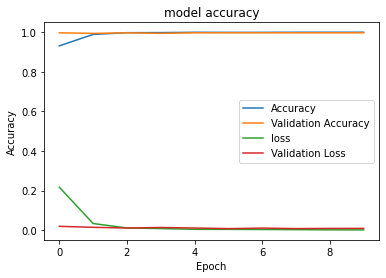

In [ ]:
#visualize training and testing data 
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

##Save model for future use 